# Setup

In [44]:
## Setup
from notebook_utils import resolve_paths_from_parent_directory
# auto reload notebook deps
%reload_ext autoreload
%autoreload 2
resolve_paths_from_parent_directory()

# Imports

In [45]:
# imports
import datetime
from experiment_pipeline.data_loader import load_global_feature_set
from experiment_pipeline.feature_sets import bus_and_weather_features_with_stop_stats
from run_experiment import run_experiment
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

# Read Data

In [46]:
data_dir = "../data"
route_str = "B46"
station_str = "JFK"
direction_int = 1


df_route, stop_id_ls = load_global_feature_set(data_dir, route_str, station_str, direction_int)

# Model Training

In [47]:
# models = [
#     Lasso(alpha=0.05, random_state=0), 
#     RandomForestRegressor(max_depth=8, random_state=0), 
#     XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=50, random_state=0)
# ]

models = [XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=50, random_state=0)]

for model in models:
    print(model)
    print('\n')
    experiment_eval = run_experiment(
            global_feature_set=df_route,
            feature_extractor_fn=bus_and_weather_features_with_stop_stats,
            model=model,
            stop_id_ls=stop_id_ls,
            dependent_variable="passenger_count",
            split_heuristic="datetime",
            test_size=0.1,
            split_datetime=datetime.datetime(year=2021, month=9, day=17, hour=0, minute=0),
            test_period="14D",
            refit_interval=None,
            random_state=0,
            experiment_name=None
        )
    print('\n')
    print("Train")
    model_pred_eval, mean_pred_eval = experiment_eval.regression_metrics("train", pretty_print=True)
    print('\n')
    print('-----------------------------')
    print('\n')
    print("Test")
    model_pred_eval, mean_pred_eval = experiment_eval.regression_metrics("test", pretty_print=True)
    print('\n')
    print('=============================')
    print('\n')

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


split: fitting on train data until 2021-09-17 00:00:00: 95,279 rows
split: testing from 2021-09-17 00:00:00 to 2021-10-01 00:00:00: 22,114 rows
Fitting model...
Inference...


Train
Performance: Model Prediction
MAE: 5.1
ME : 77.7
R^2: 0.46


Performance: Mean Prediction
MAE: 7.3
ME : 74.4
R^2: 0.00


---------------------------

## We can also think about our problem as a classification task (e.g. high / medium / low occupancy)

In [48]:
# method (all stats computed on a per-stop basis)
# mean (2 classes only):    label crowded if occupancy >= mean, else not crowded
# q50 (2 classes only):     label crowded if occupancy >= median, else not crowded
# q25q75 (2 or 3 classes):  2 classes - label crowded if occupancy > 75th percentile, else not crowded
#                           3 classes - label crowded if occupancy > 75th percentile, label sparse if occupancy < 25th percentile, else normal
# std (2 or 3 classes):     2 classes - label crowded if occupancy > mean + std * spread_multiple, else not crowded
#                           3 classes - label crowded if occupancy > mean + std * spread_multiple, label sparse if occupancy mean + std * spread_multiple, else normal
# iqr (2 or 3 classes):     2 classes - label crowded if occupancy > 75th percentile + iqr * spread_multiple, else not crowded
#                           3 classes - label crowded if occupancy > 75th percentile + iqr * spread_multiple, label sparse if occupancy 25th percentile  iqr * spread_multiple, else normal

bal_acc, cr_dict, cm = experiment_eval.classification_metrics('test', segment=None, method='q25q75', num_classes=3, spread_multiple=1, pretty_print=True)

Labels: -1 = sparse | 0 = normal | 1 = crowded


Balanced Accuracy: 0.40633794803383577


Classification Report:
              precision    recall  f1-score   support

          -1       0.62      0.05      0.10      4801
           0       0.55      0.83      0.66     11612
           1       0.46      0.34      0.39      5701

    accuracy                           0.53     22114
   macro avg       0.54      0.41      0.38     22114
weighted avg       0.54      0.53      0.47     22114



Confusion Matrix:
[[ 255 4139  407]
 [ 130 9644 1838]
 [  23 3766 1912]]


# Visualizations (all plots work for train and test sets)

## Total predicted vs. ground truth passenger count by hour of day (whole route)

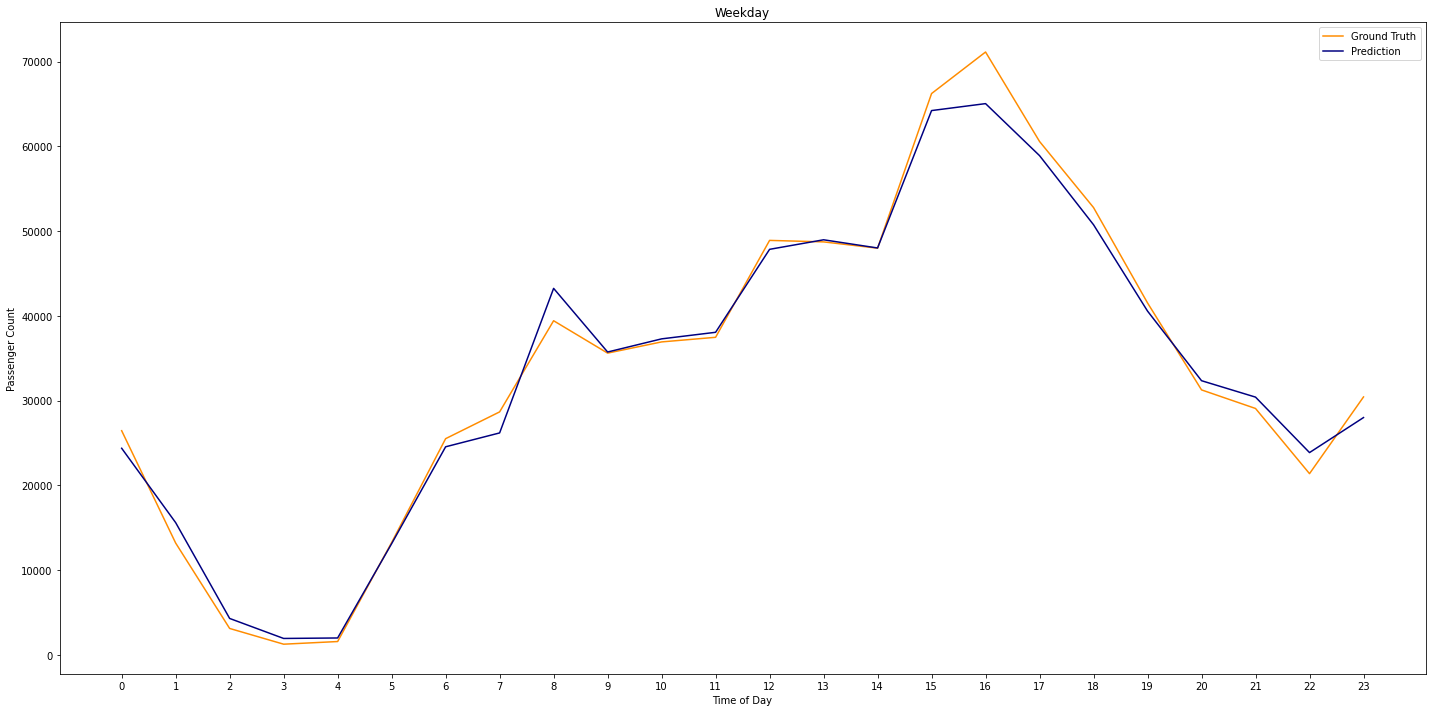

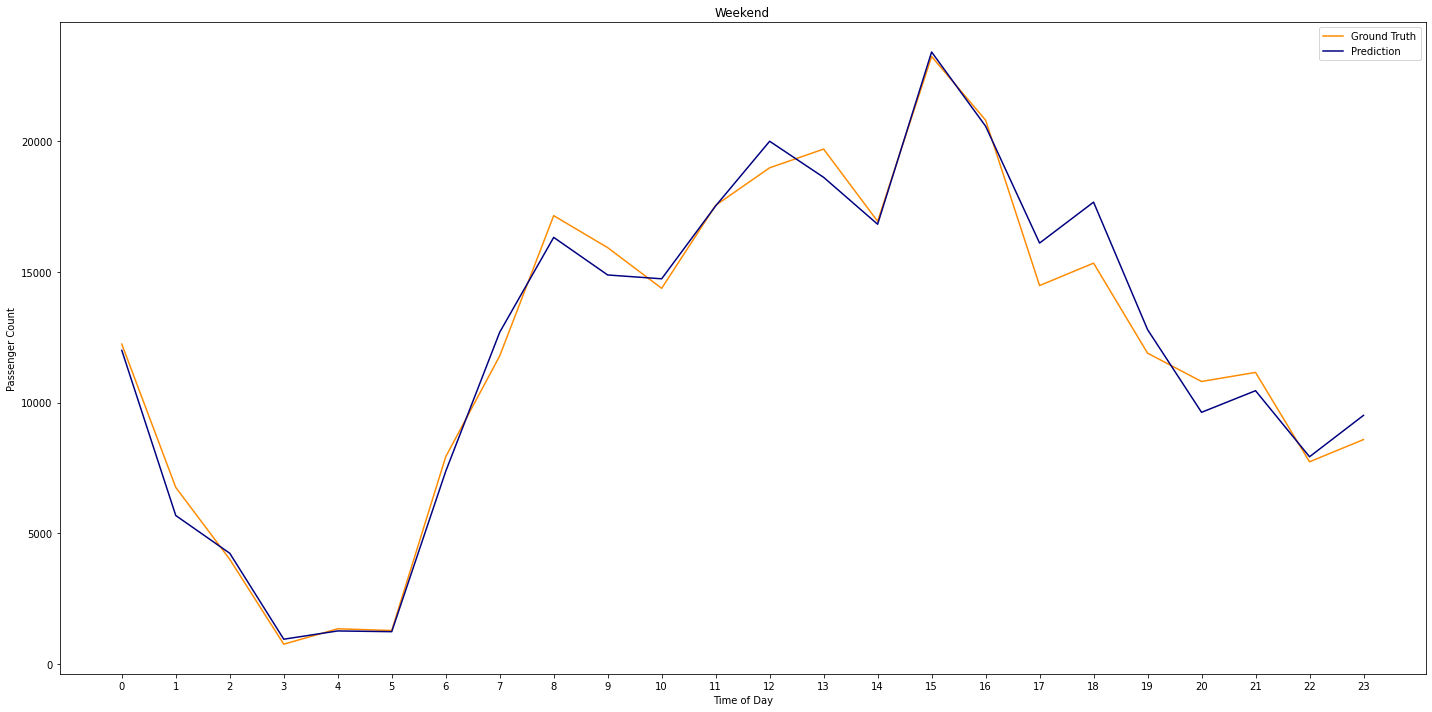

In [49]:
# note: plot_passenger_count_by_time_of_day will only ever return non-null values for fig_weekday and fig_weekend;
# fig_datetime included for consistency with gt_pred_scatter API
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=None, agg='sum')

## Mean predicted vs. ground truth passenger count by hour of day (whole route)

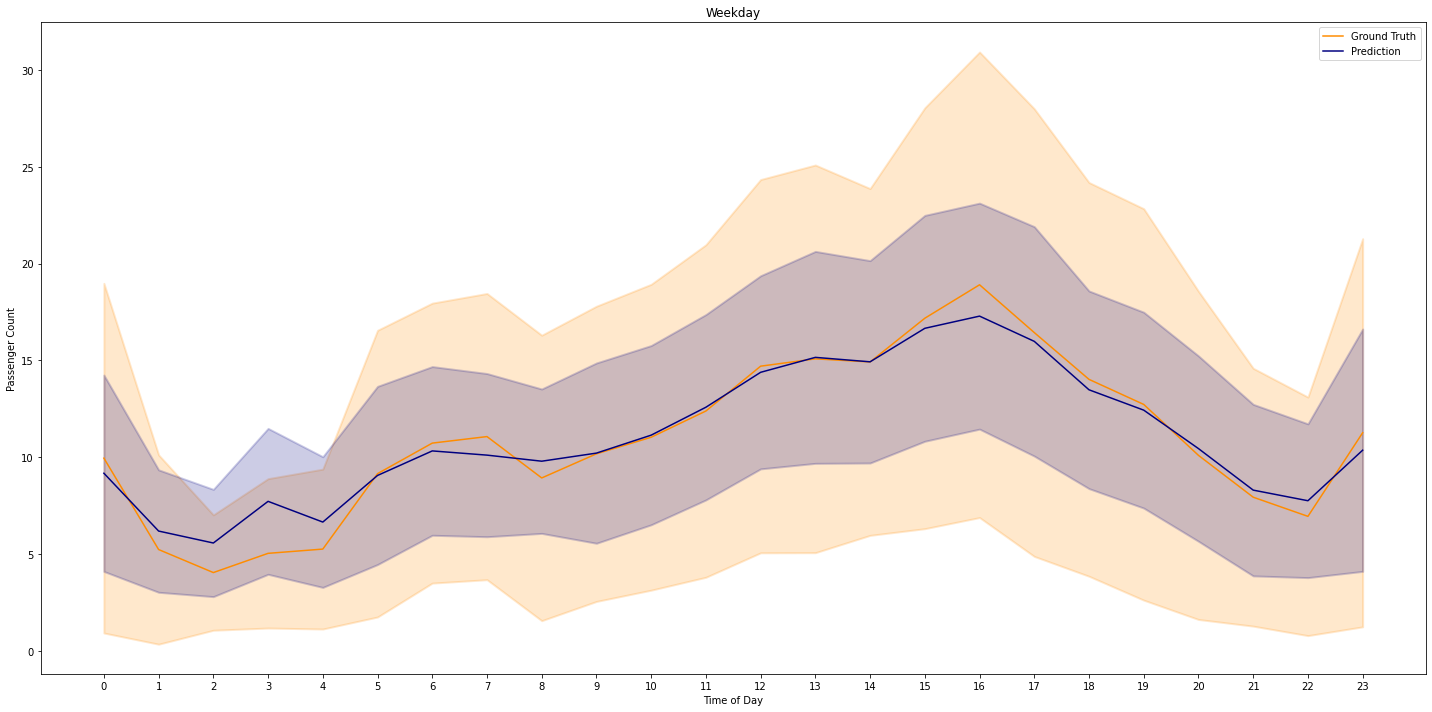

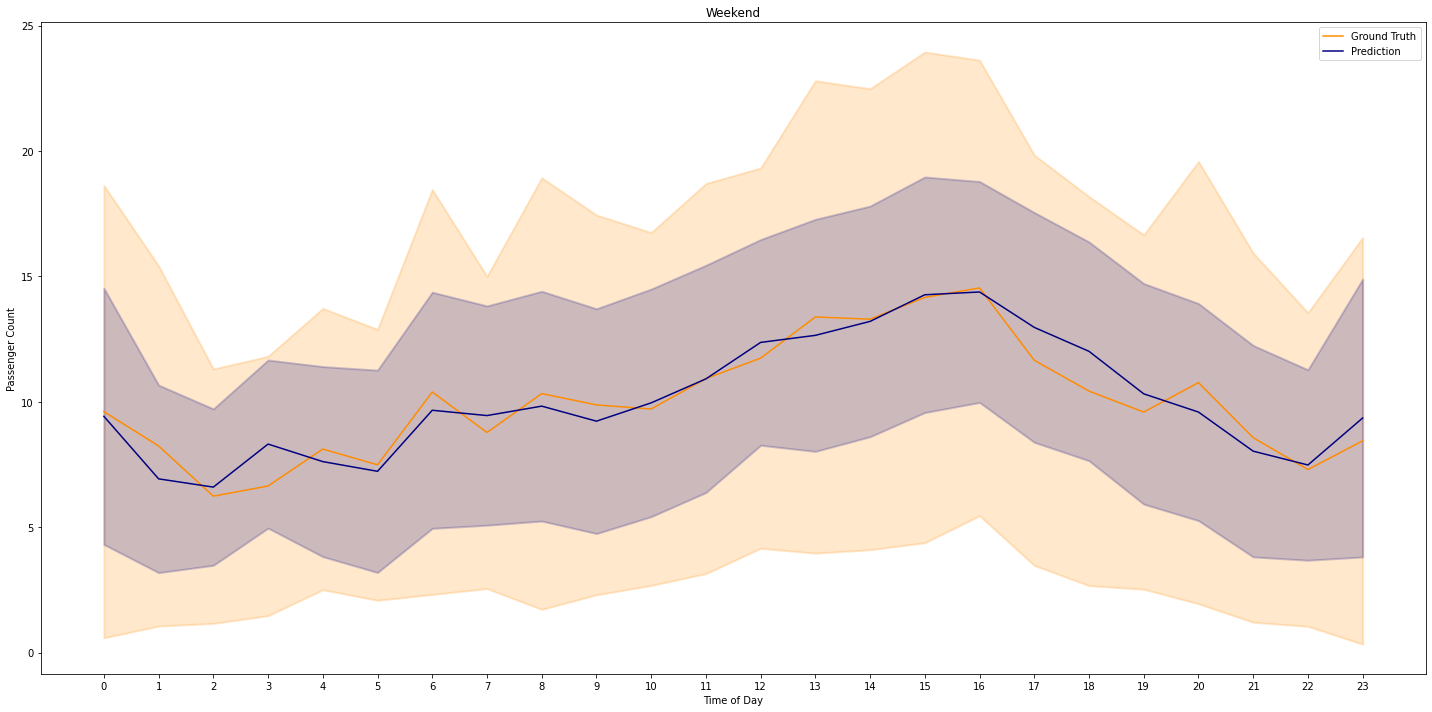

In [50]:
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=None, agg='mean')

## Total predicted vs. ground truth passenger count by hour of day (single stop)

MTA_303673


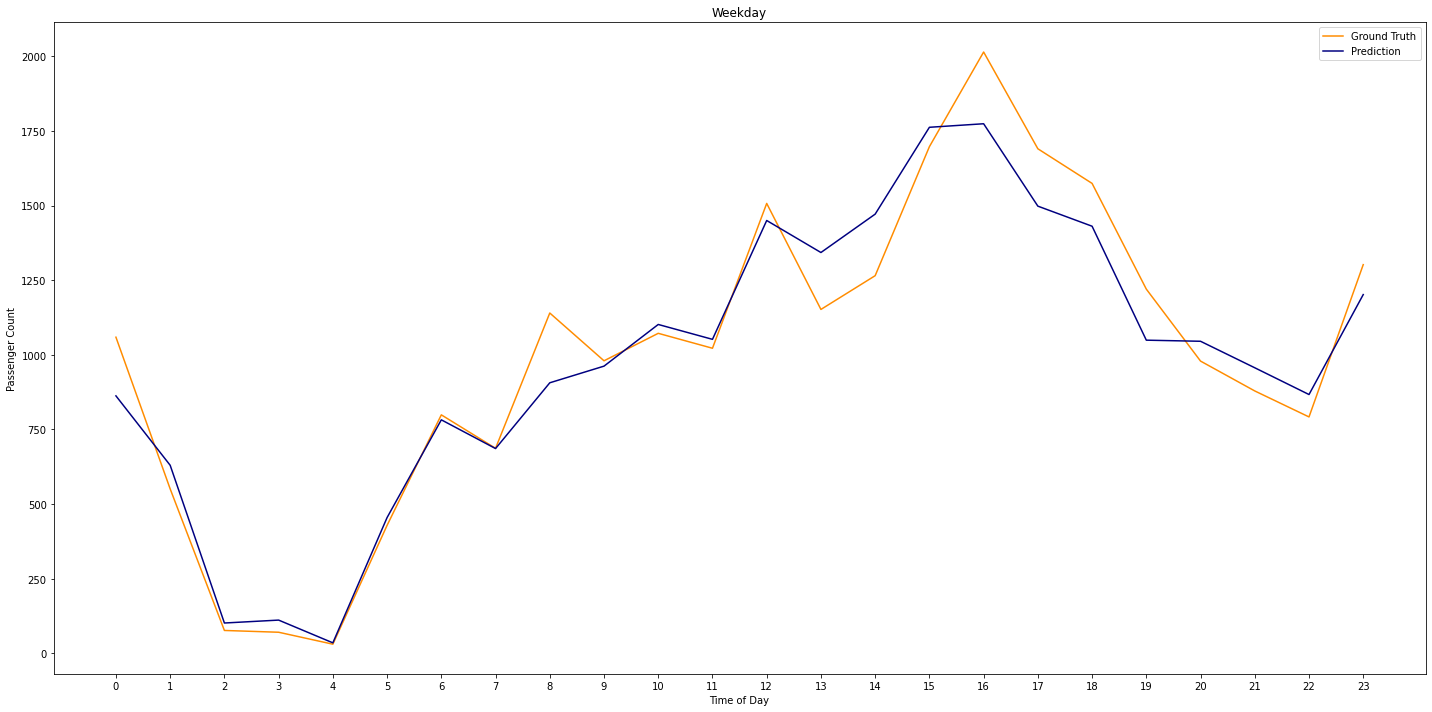

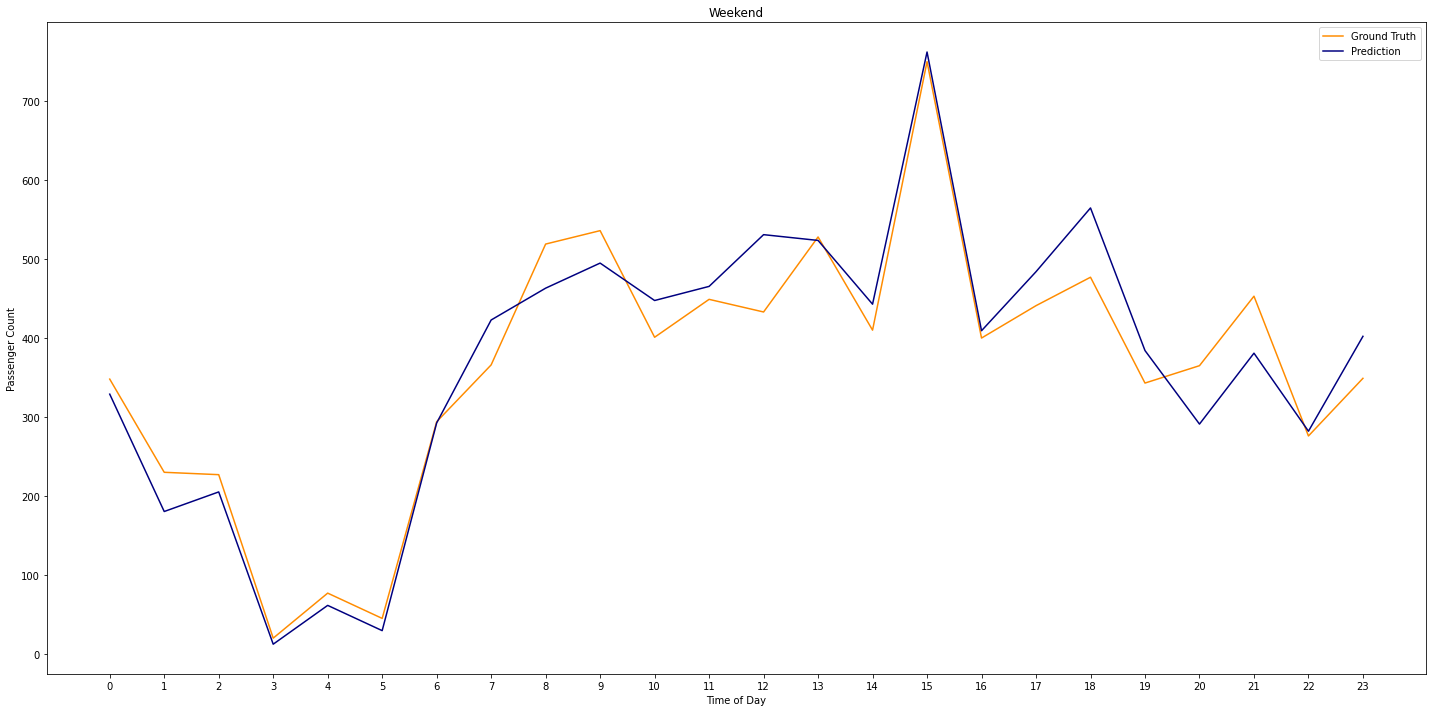

In [51]:
stop_pos = 20
stop_id = experiment_eval.stop_pos2stop_id[stop_pos]
print(stop_id)

# note: segment parameter needs to correspond to stop position int
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=stop_pos, agg='sum')

## Mean predicted vs. ground truth passenger count by hour of day (single stop)

MTA_303663


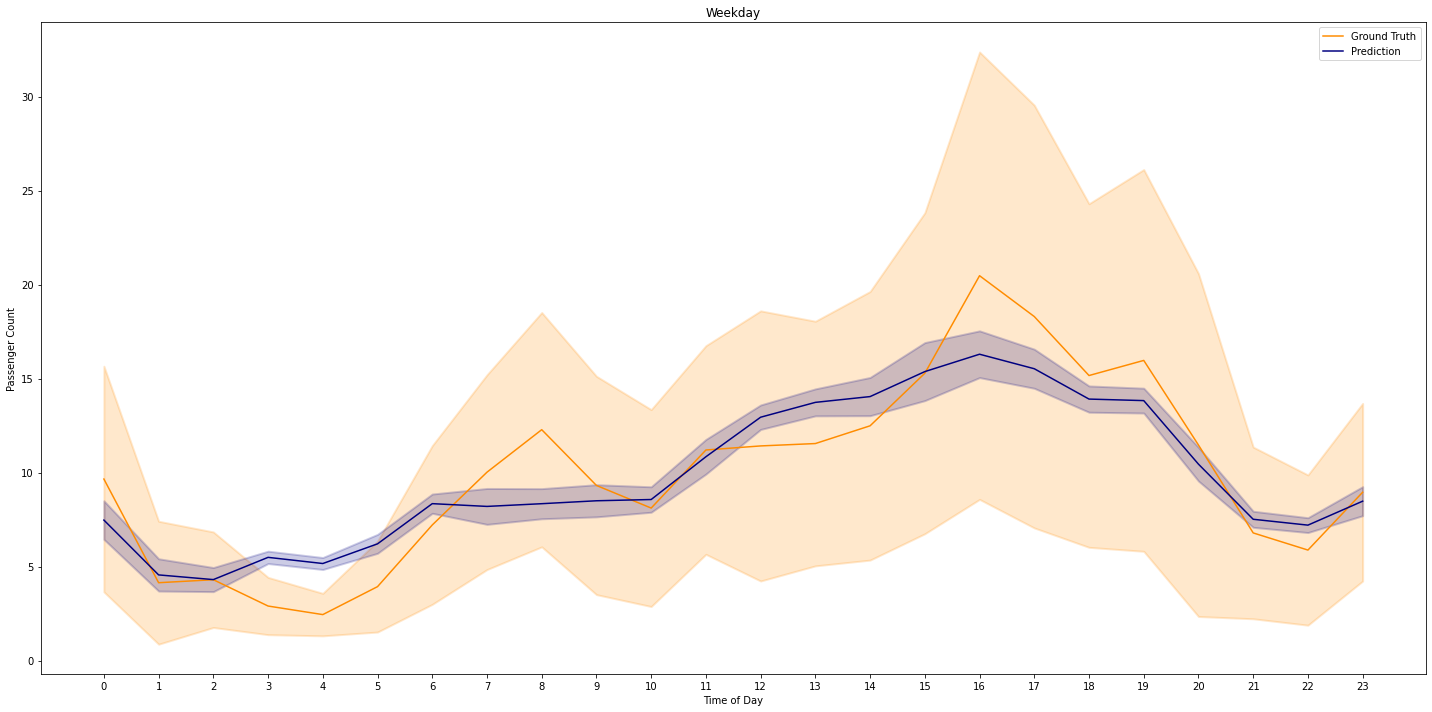

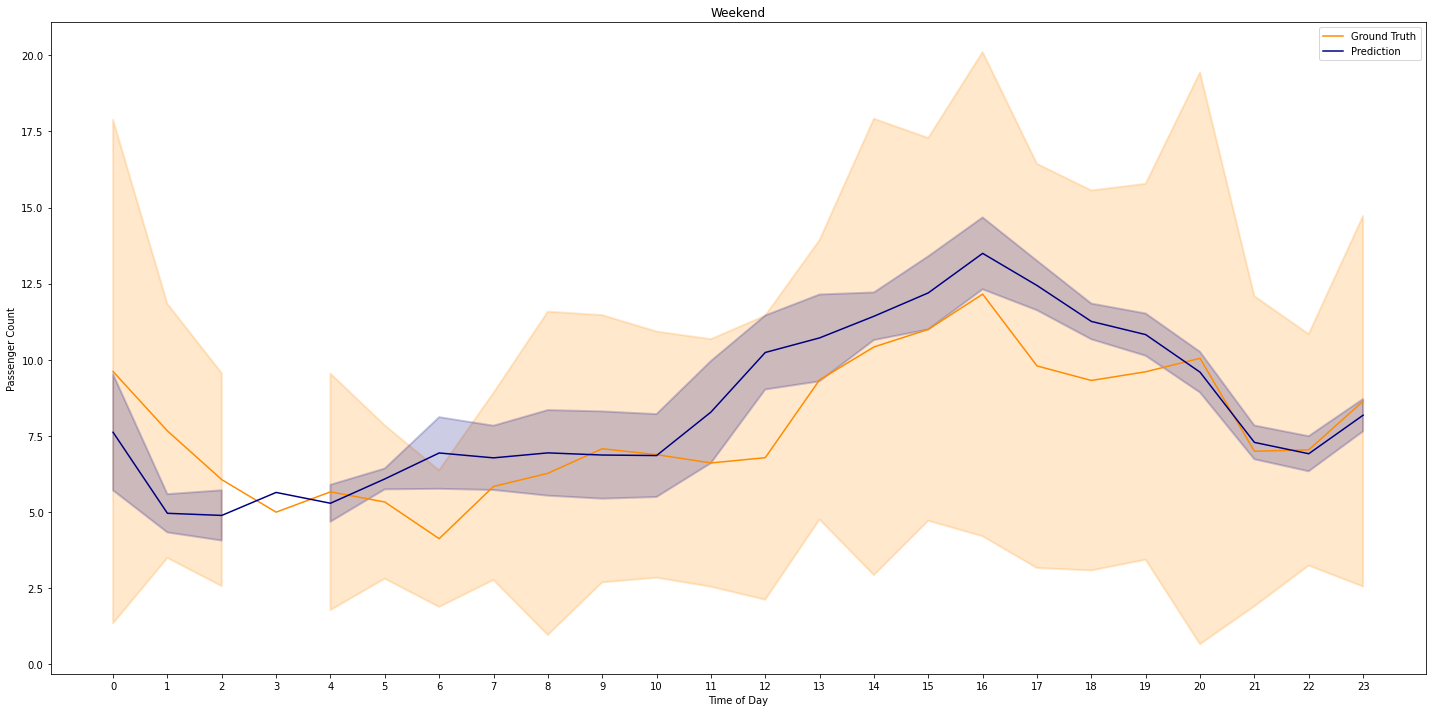

In [52]:
stop_pos = 12
stop_id = experiment_eval.stop_pos2stop_id[stop_pos]
print(stop_id)

# note: segment parameter needs to correspond to stop position int
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=stop_pos, agg='mean')

## Prediction vs. ground truth scatter plots:

### Simple (all errors)

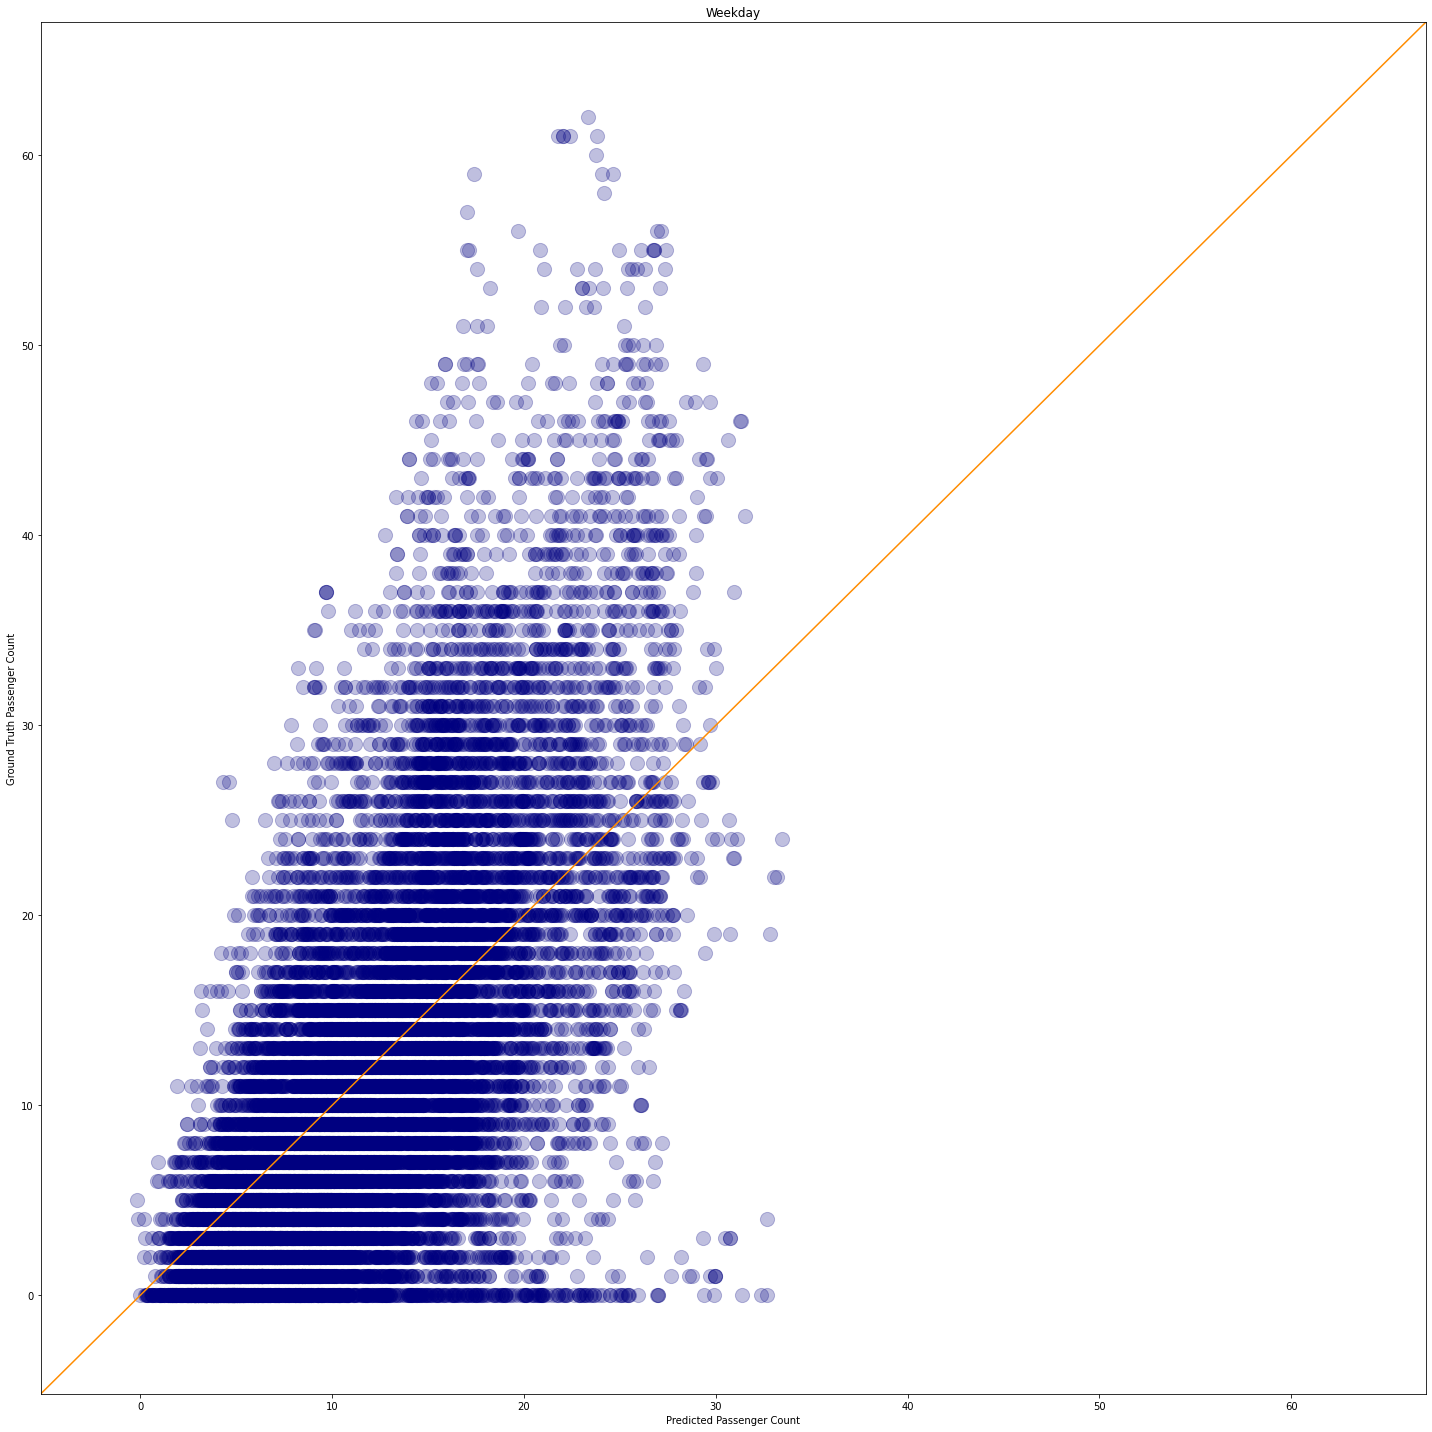

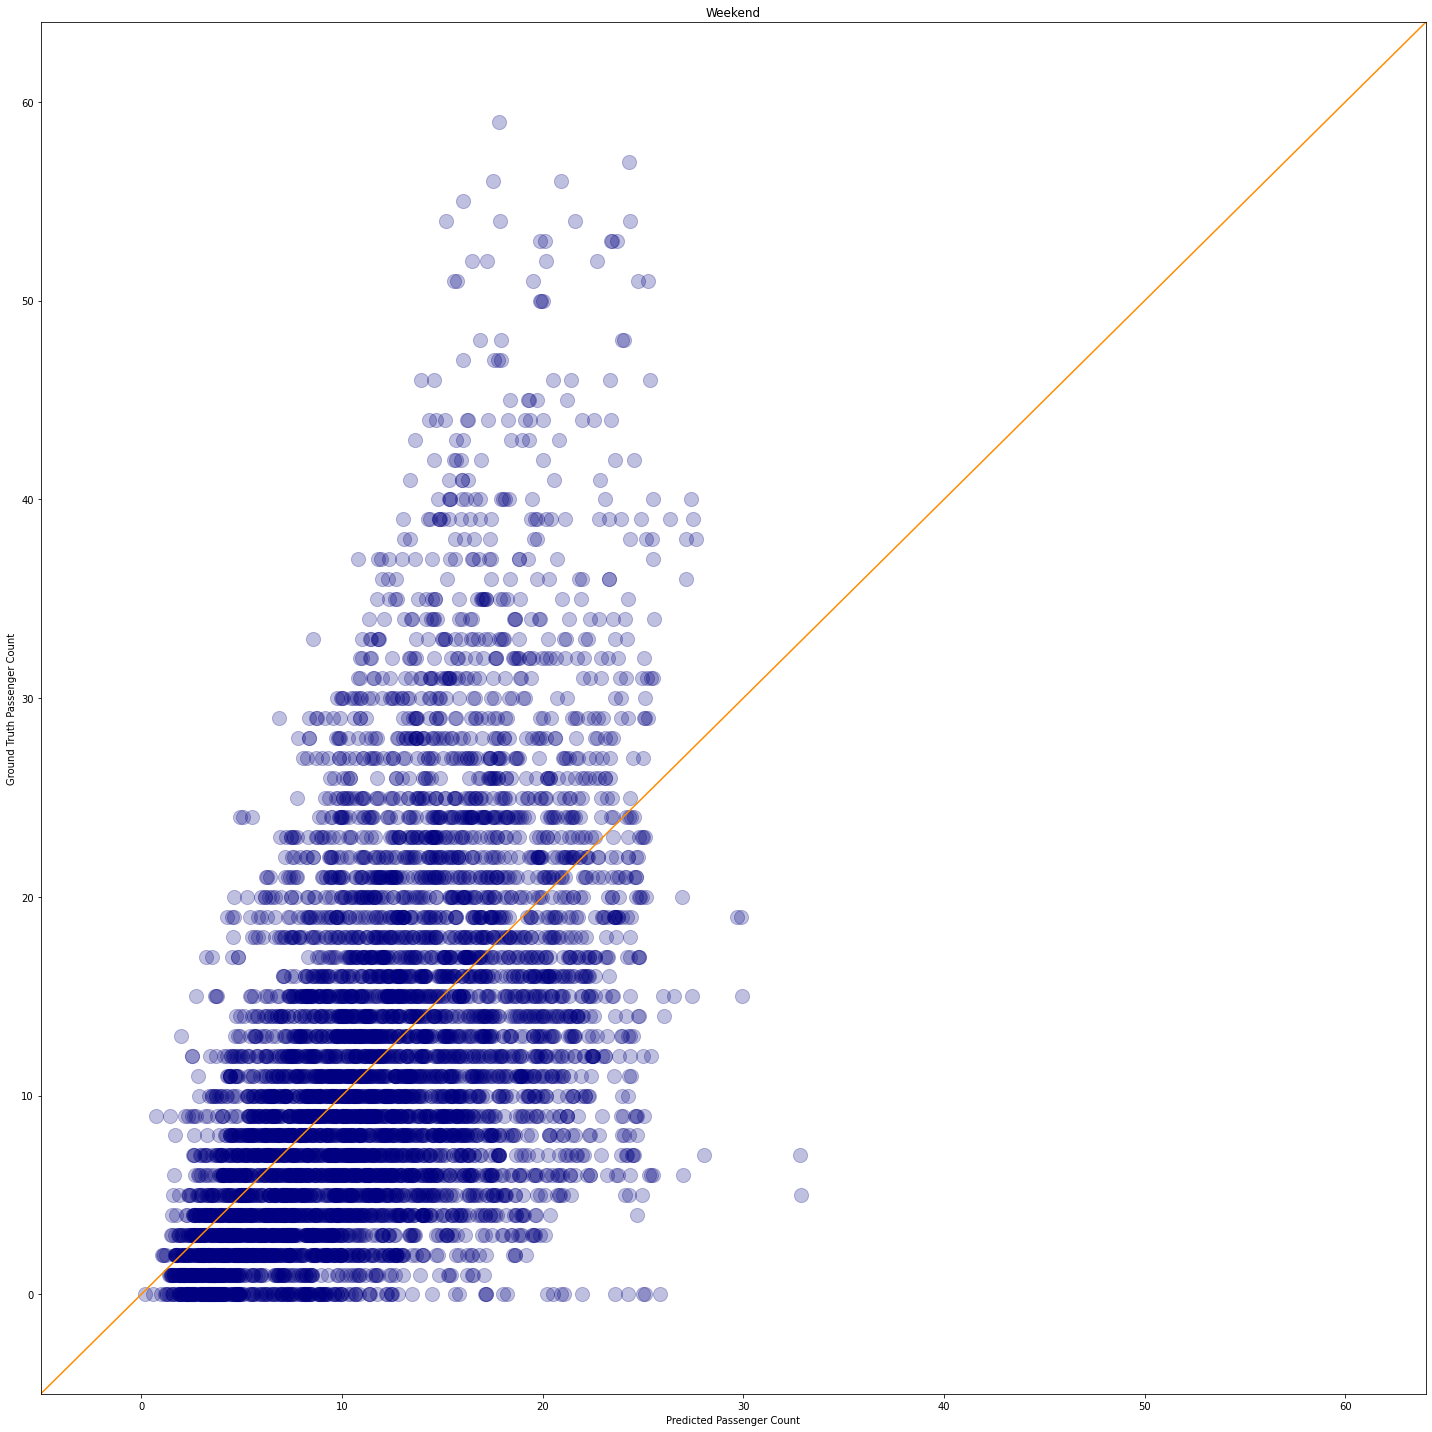

In [53]:
# note: parameter gt_y not needed when plot='simple';
#       parameter n not needed errors='all'
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='simple', errors='all', n=100, s=200, gt_y=True)

### By stop - 500 largest errors; predictions plotted in relation to ground truth (i.e. gt_y=True)

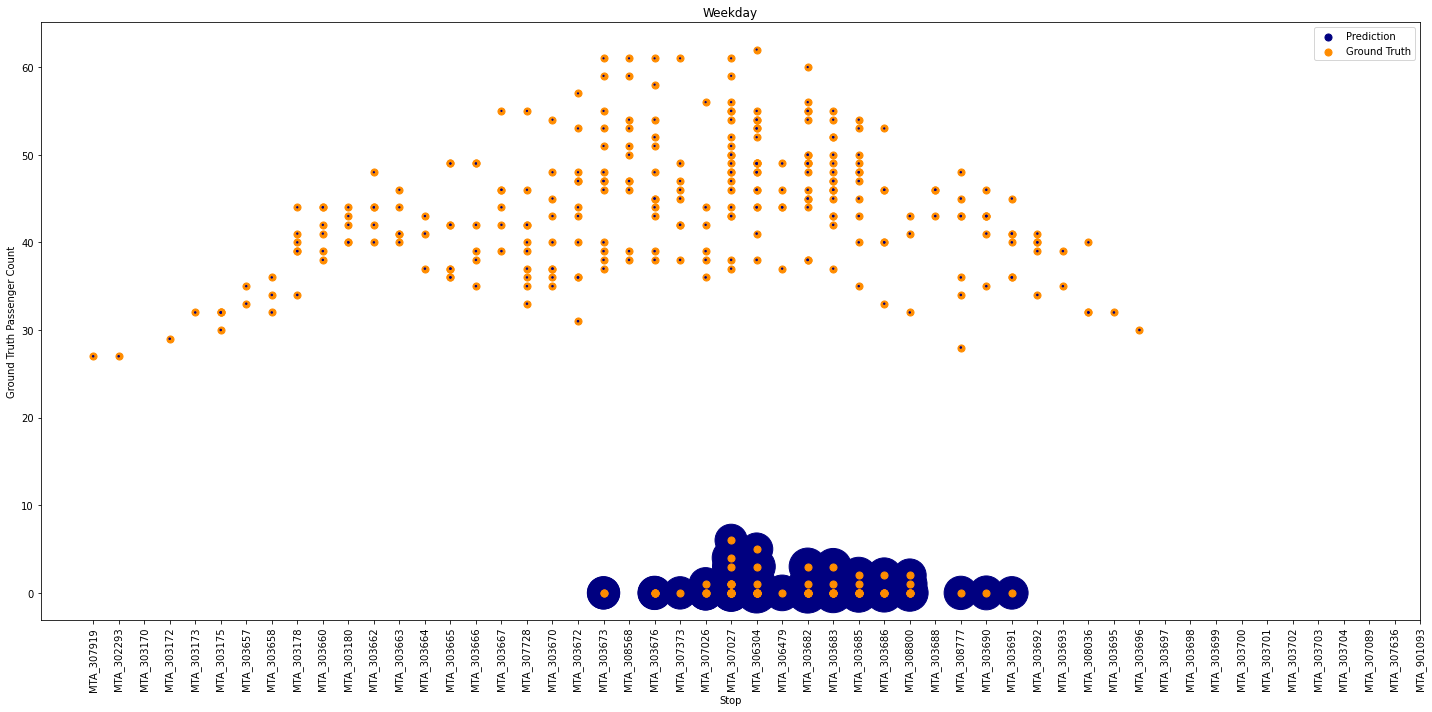

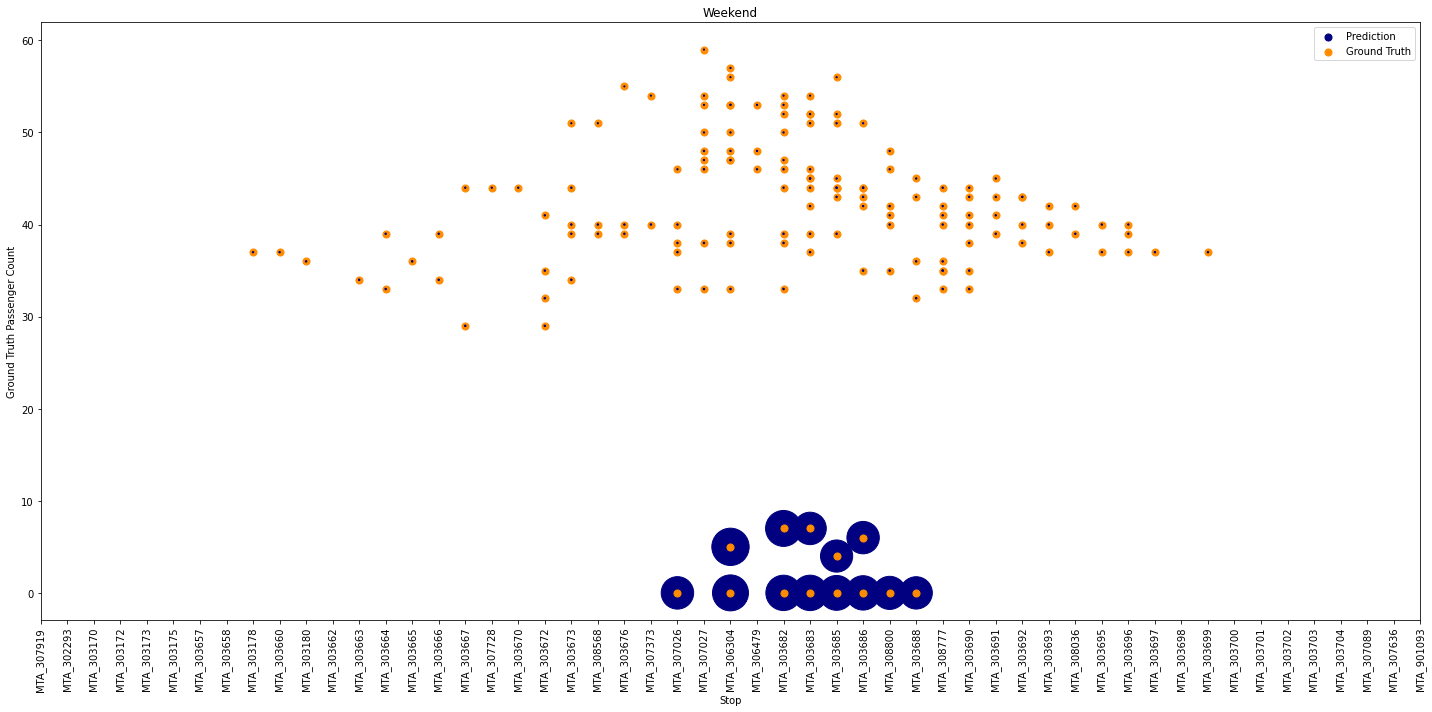

In [54]:
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='stop', errors='large', n=500, s=50, gt_y=True)

### By stop - 500 largest errors; ground truth plotted in relation to predictions (i.e. gt_y=False)

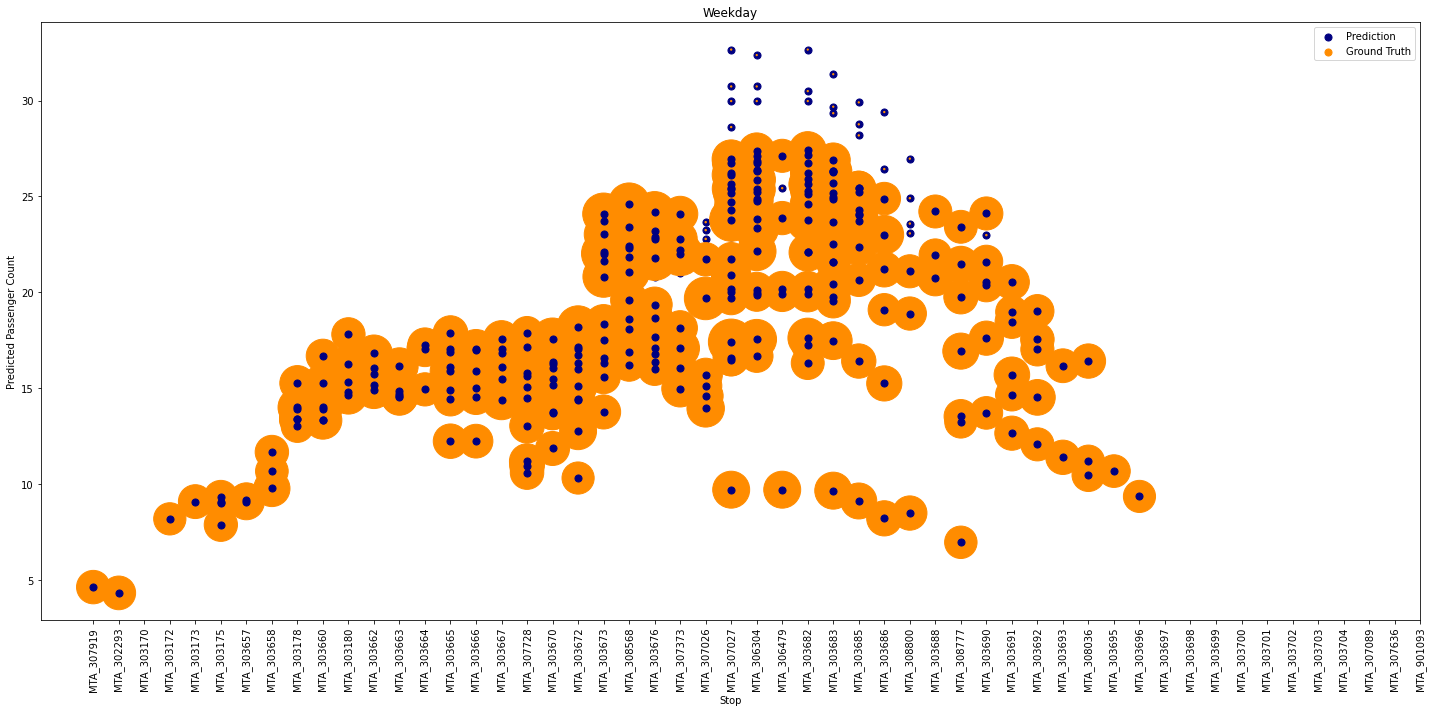

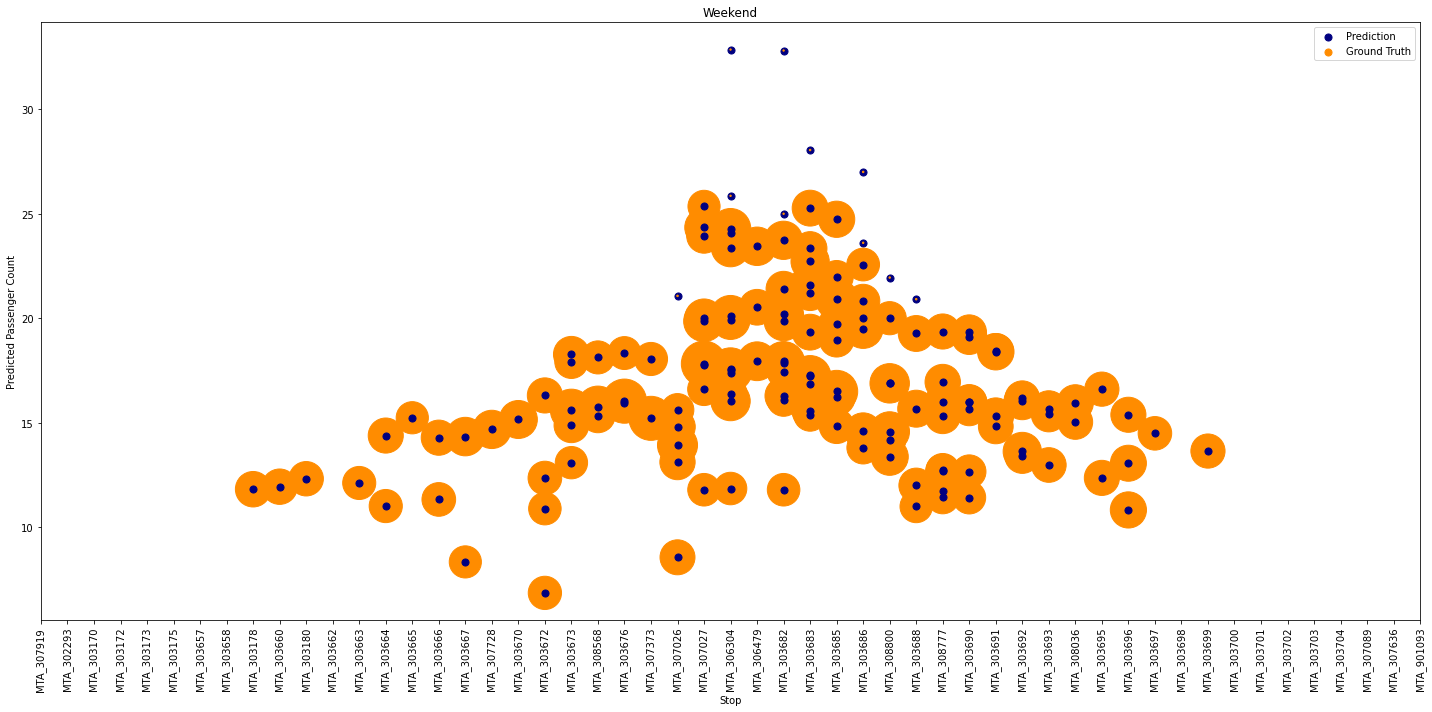

In [55]:
# note: plotting ground truth in relation to predictions tends to result in more visible markers since two observations close together in
# time that have the same ground truth passenger_count will appear as basically the same datapoint in the above plot. in the below chart,
# however, since the predicted passenger_count for these two observations tends to vary, they will appear as two datapoints 
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='stop', errors='large', n=500, s=50, gt_y=False)

### By hour - 500 smallest errors; predictions plotted in relation to ground truth (i.e. gt_y=True)

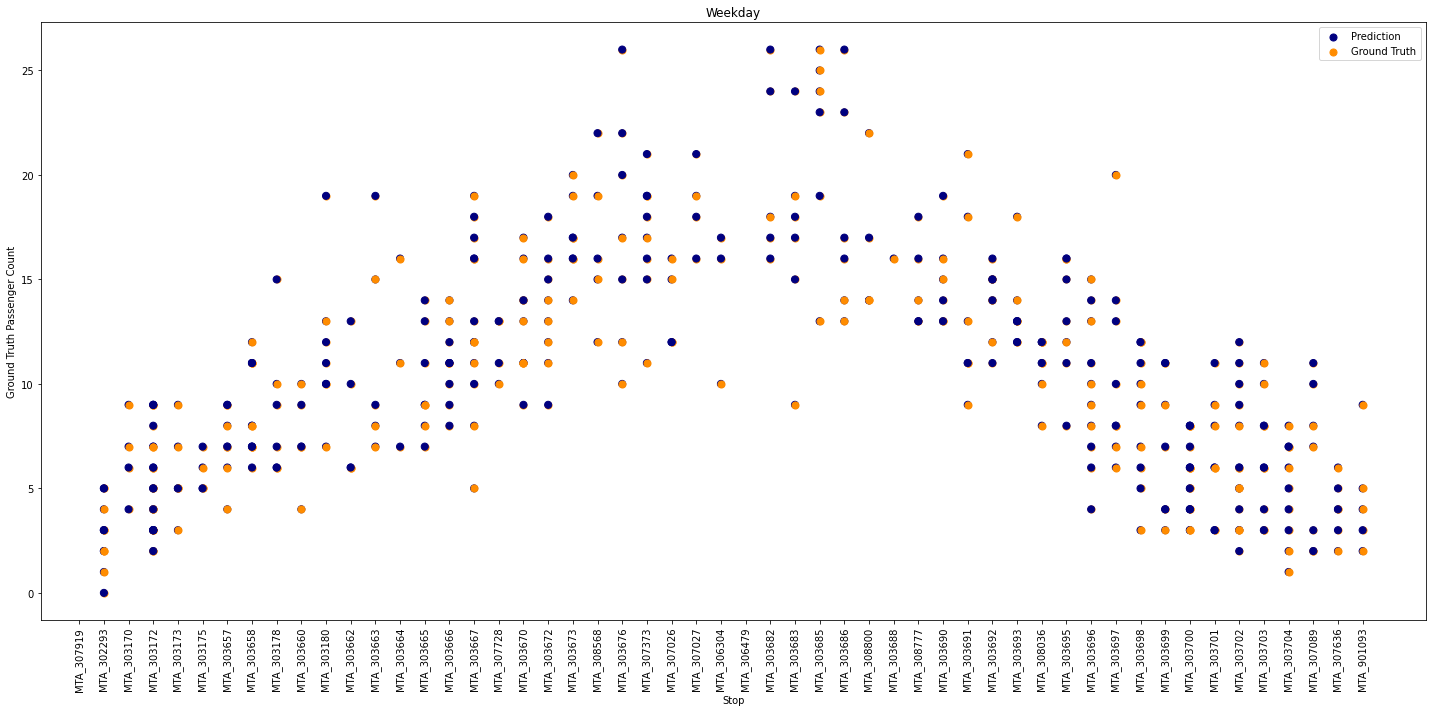

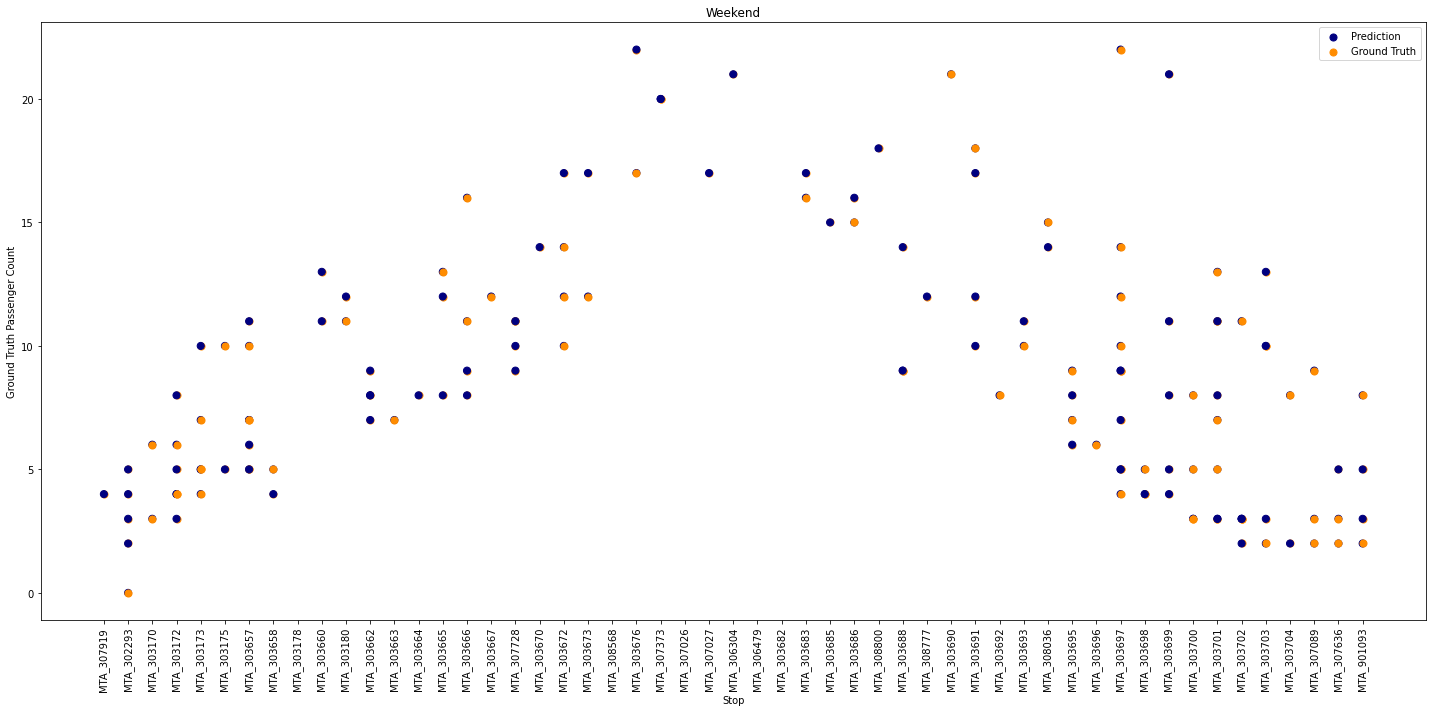

In [56]:
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='stop', errors='small', n=500, s=50, gt_y=True)

### By datetime - 500 largest errors; predictions plotted in relation to ground truth (i.e. gt_y=True)

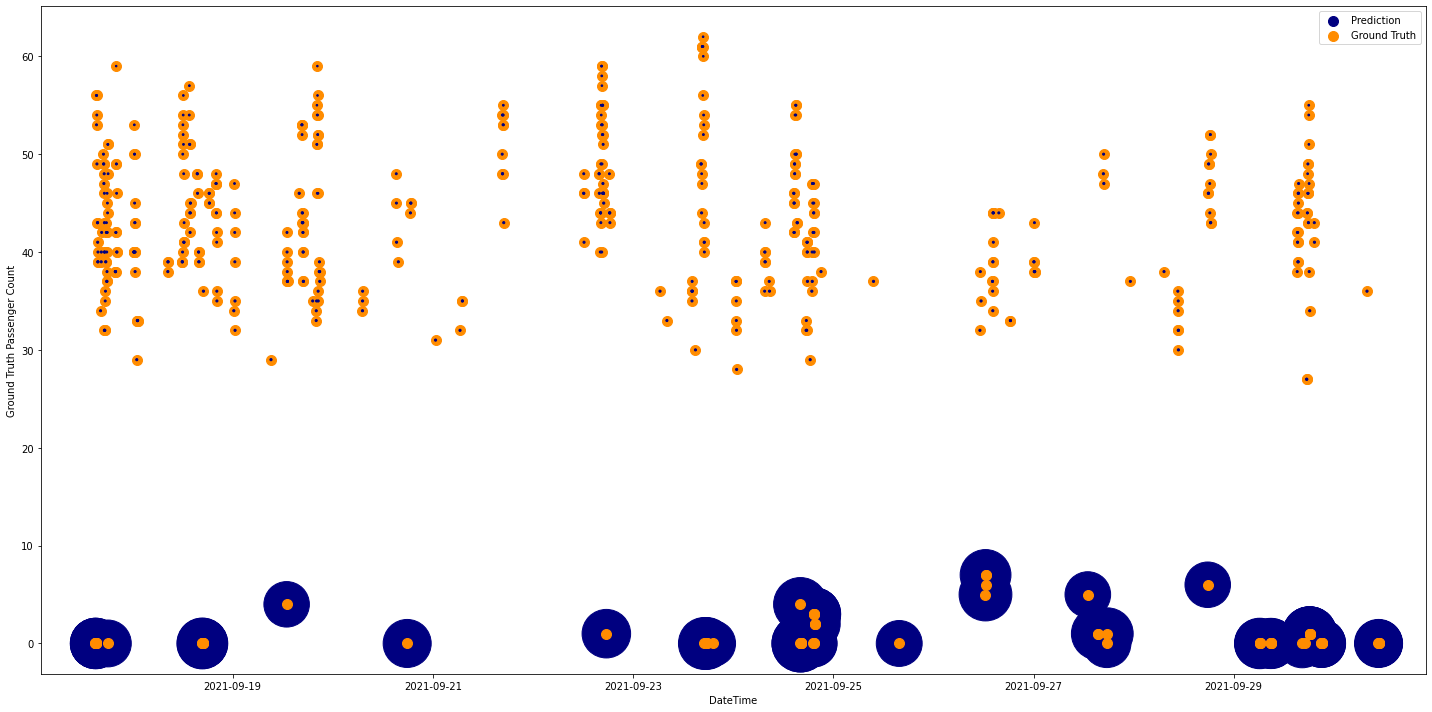

In [65]:
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='datetime', errors='large', n=500, s=100, gt_y=True, overlay_weather=False)

### Similar plot but overlay weather events

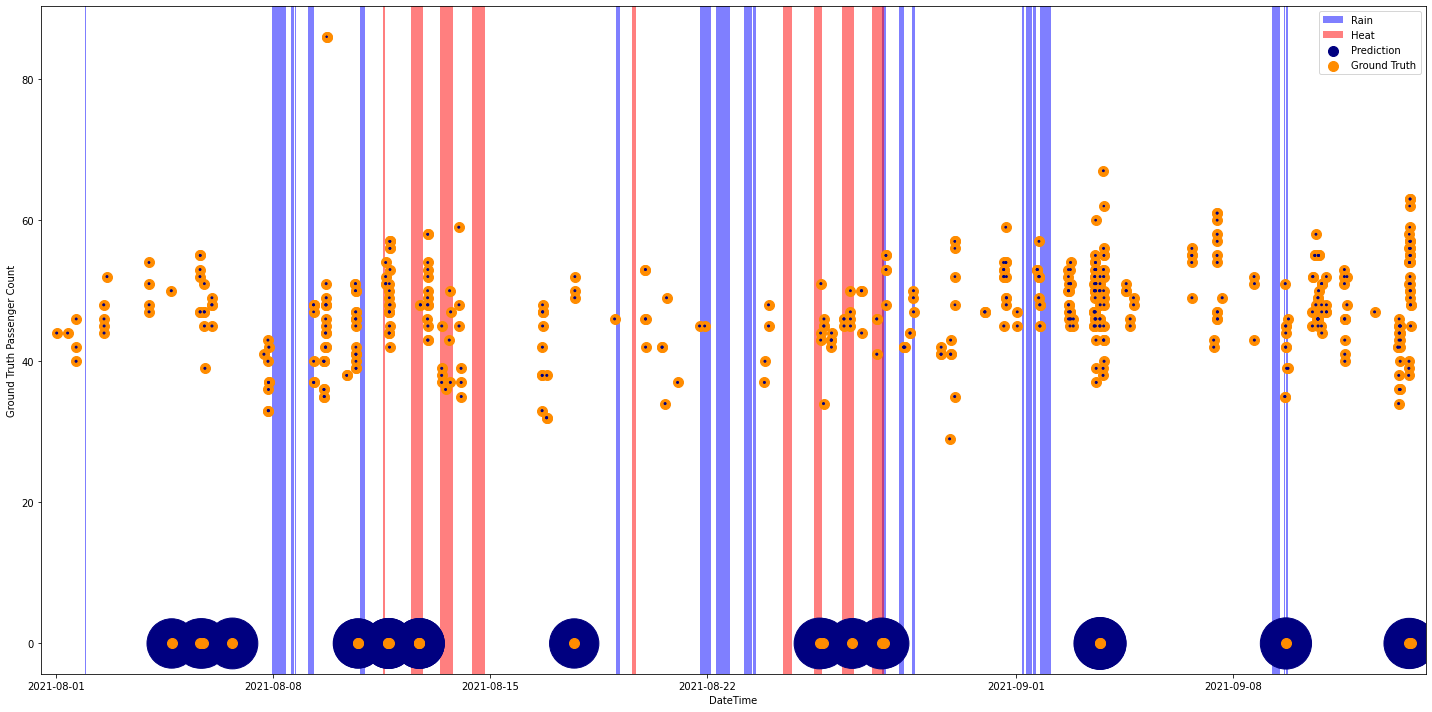

In [66]:
# note: switched back to train set here since the particular testing dates we looked at in our partition did not include any weather events
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('train', plot='datetime', errors='large', n=500, s=100, gt_y=True, overlay_weather=True)

# Feature Analysis

## Inspect feature correlation

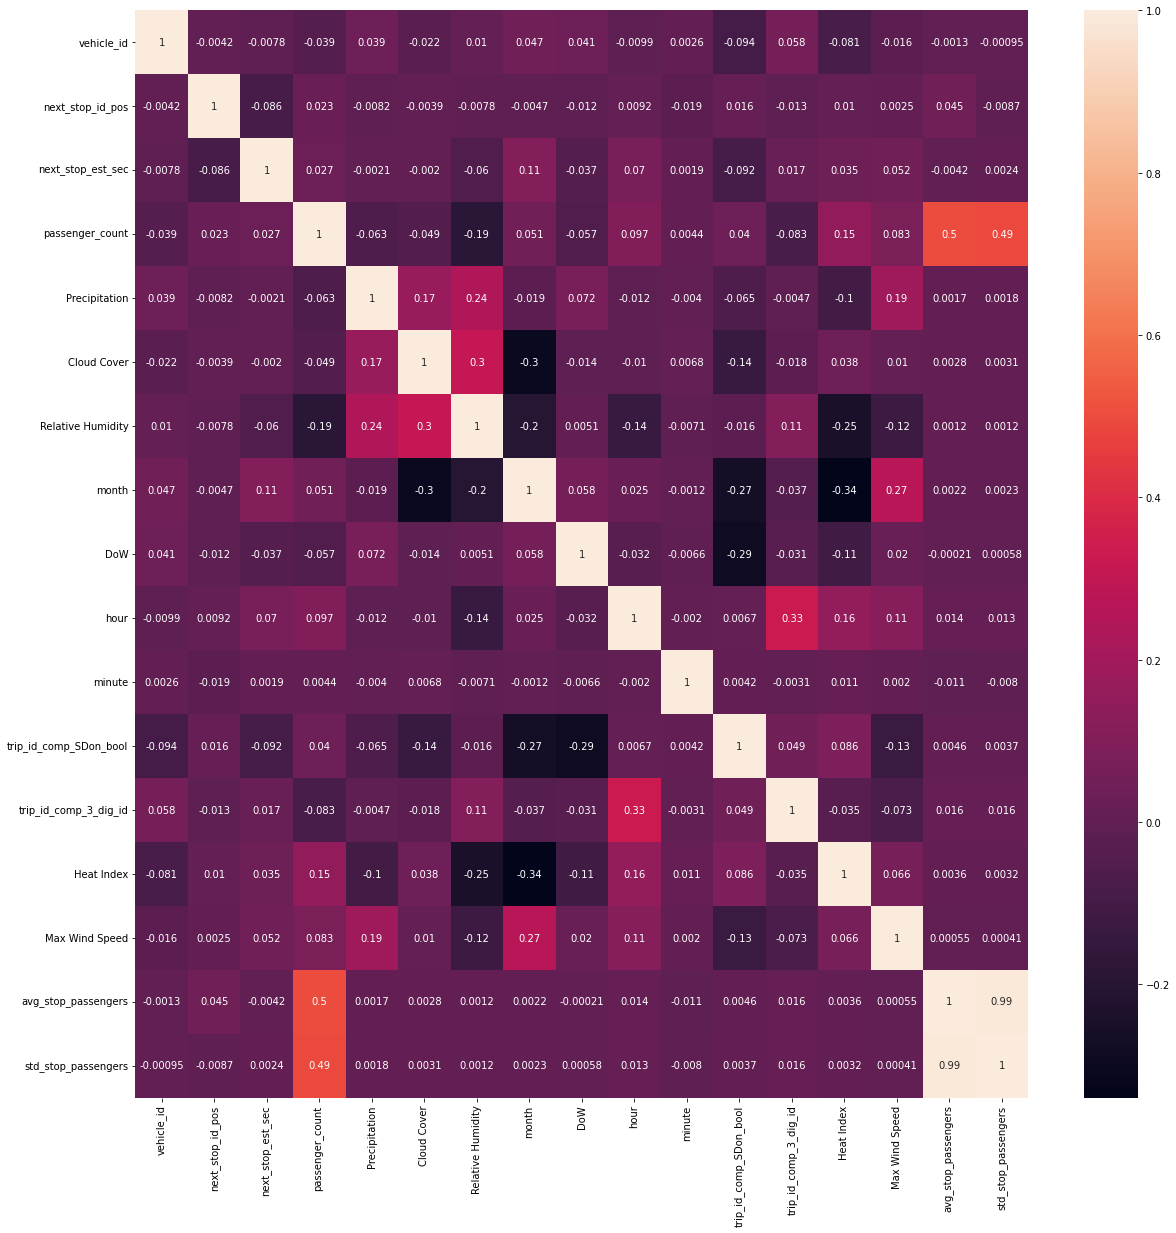

In [67]:
# all features
fig = experiment_eval.plot_feature_correlation(subset=None)

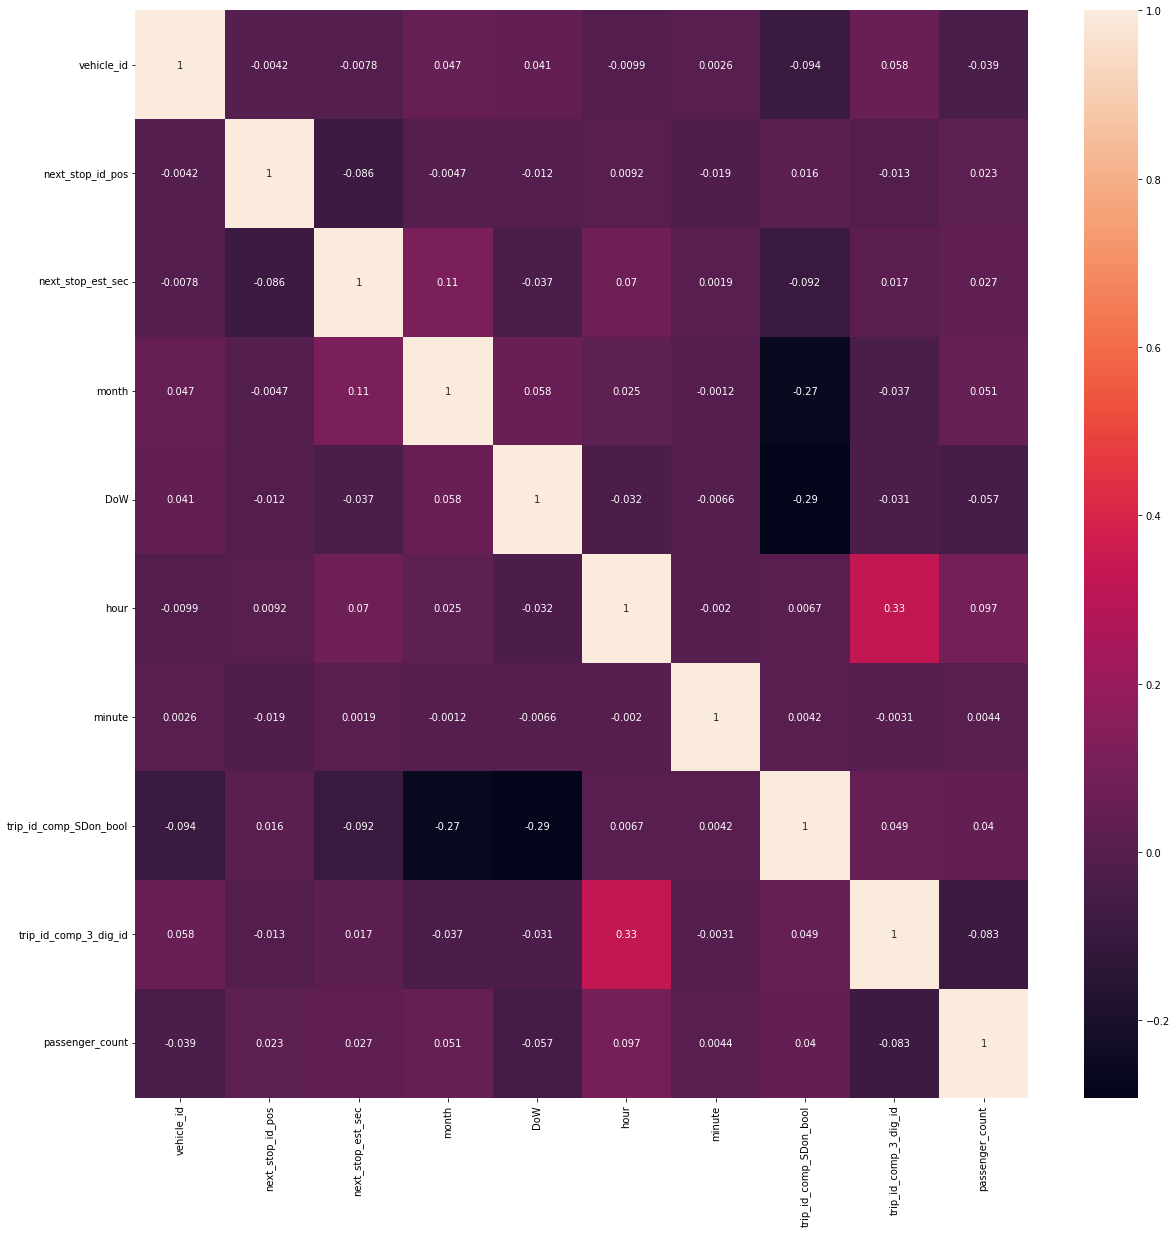

In [68]:
bus_features = [
    'vehicle_id',
    'next_stop_id_pos',
    'next_stop_est_sec',
    'month',    
    'DoW',  
    'hour',
    'minute',    
    'trip_id_comp_SDon_bool',
    'trip_id_comp_3_dig_id',
    # 'day',                   # always drop
    # 'year',                  # always drop
    # 'trip_id_comp_6_dig_id', # always drop
    # 'timestamp'              # always drop
]

subset = bus_features + ['passenger_count']

fig = experiment_eval.plot_feature_correlation(subset=subset)

## Plot feature importance

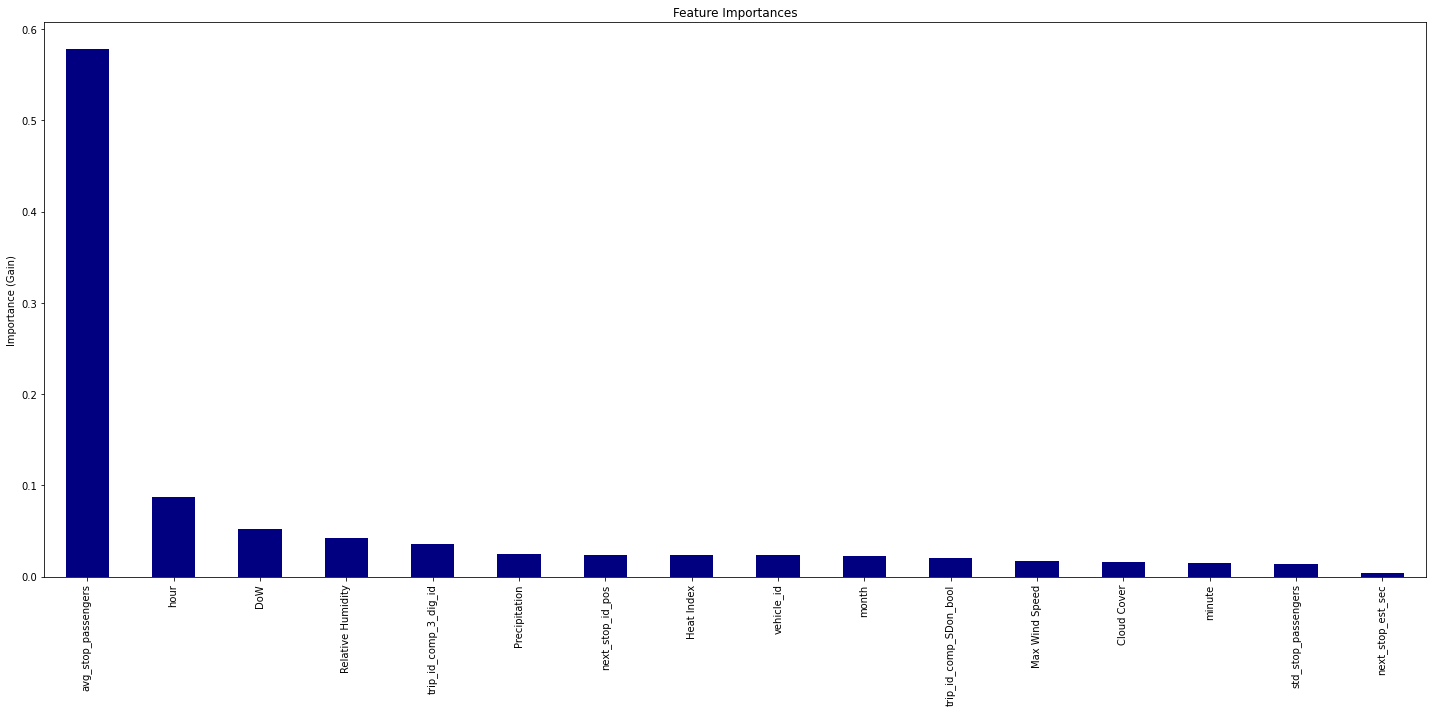

In [69]:
importance, mae, me, r2 = experiment_eval.plot_feature_importance(ablate_features=False)

## Ablate features and evaluate model performance

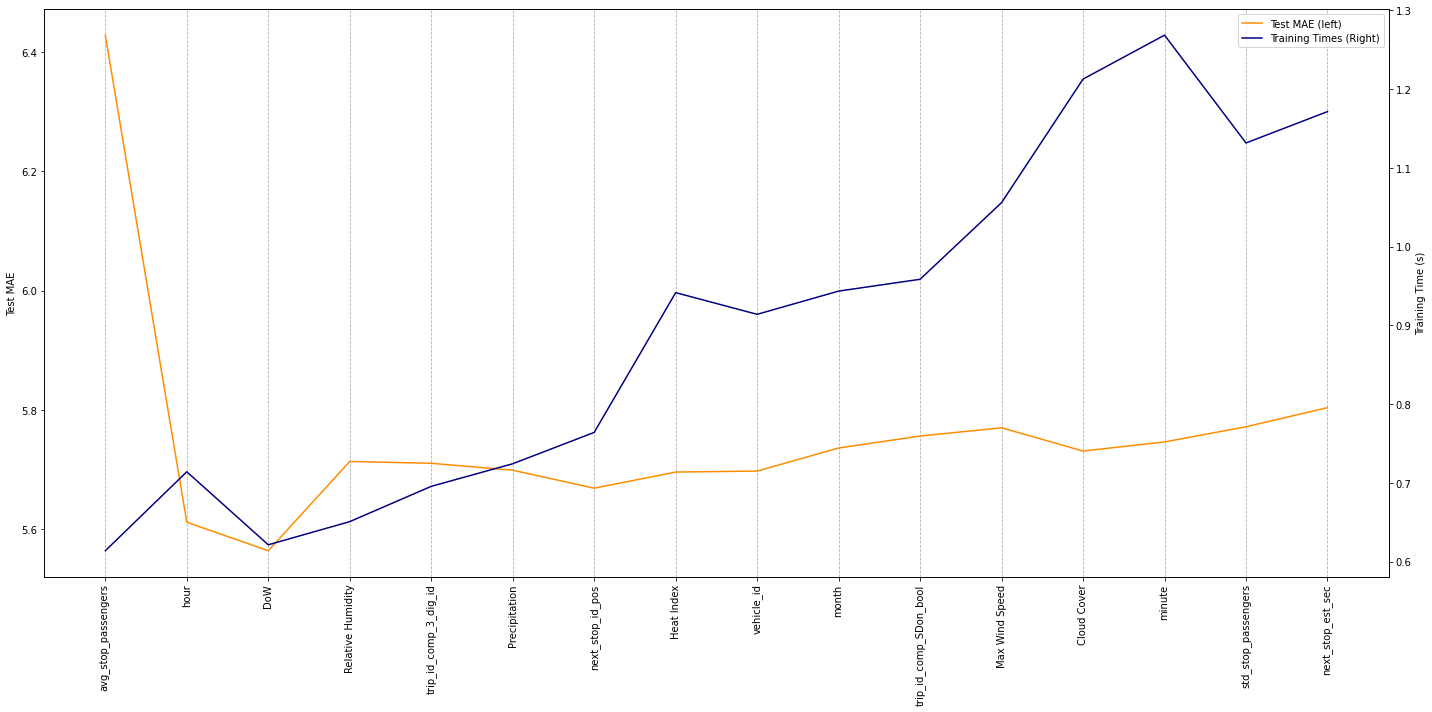

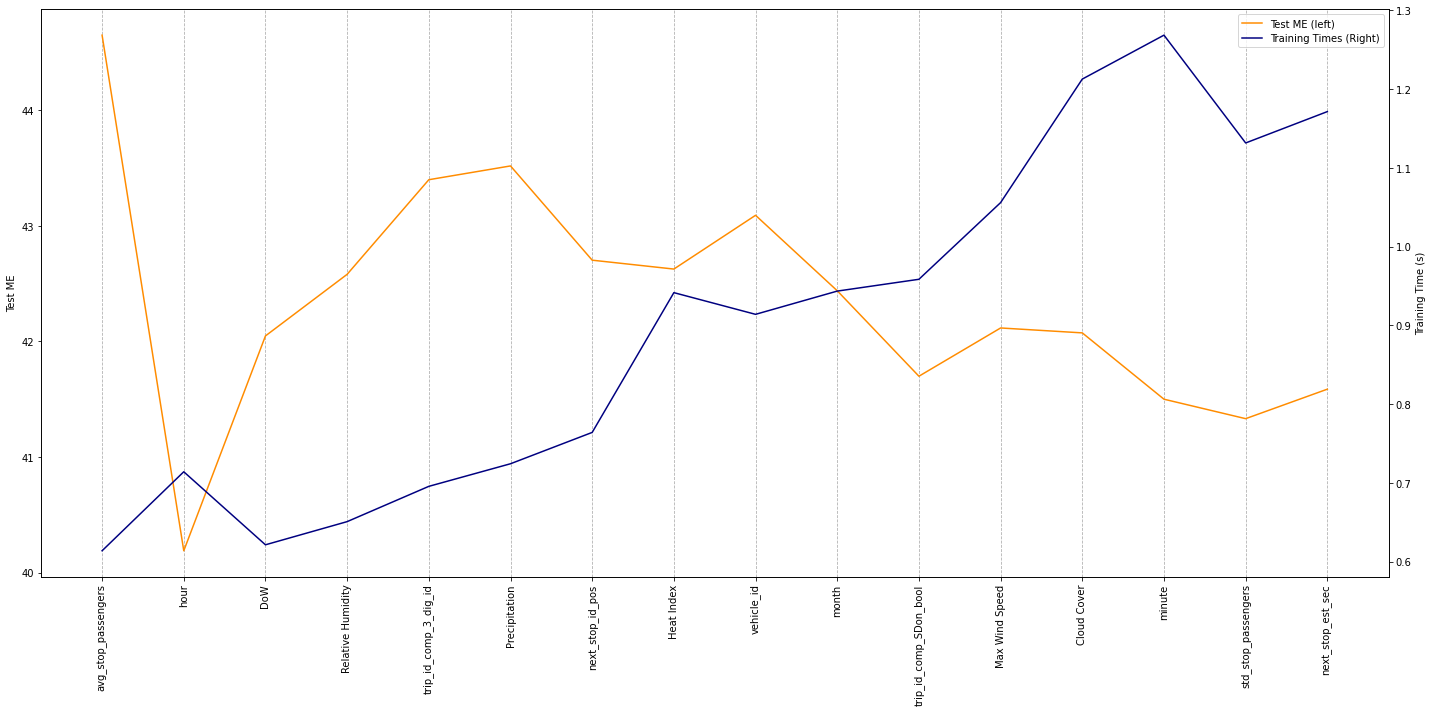

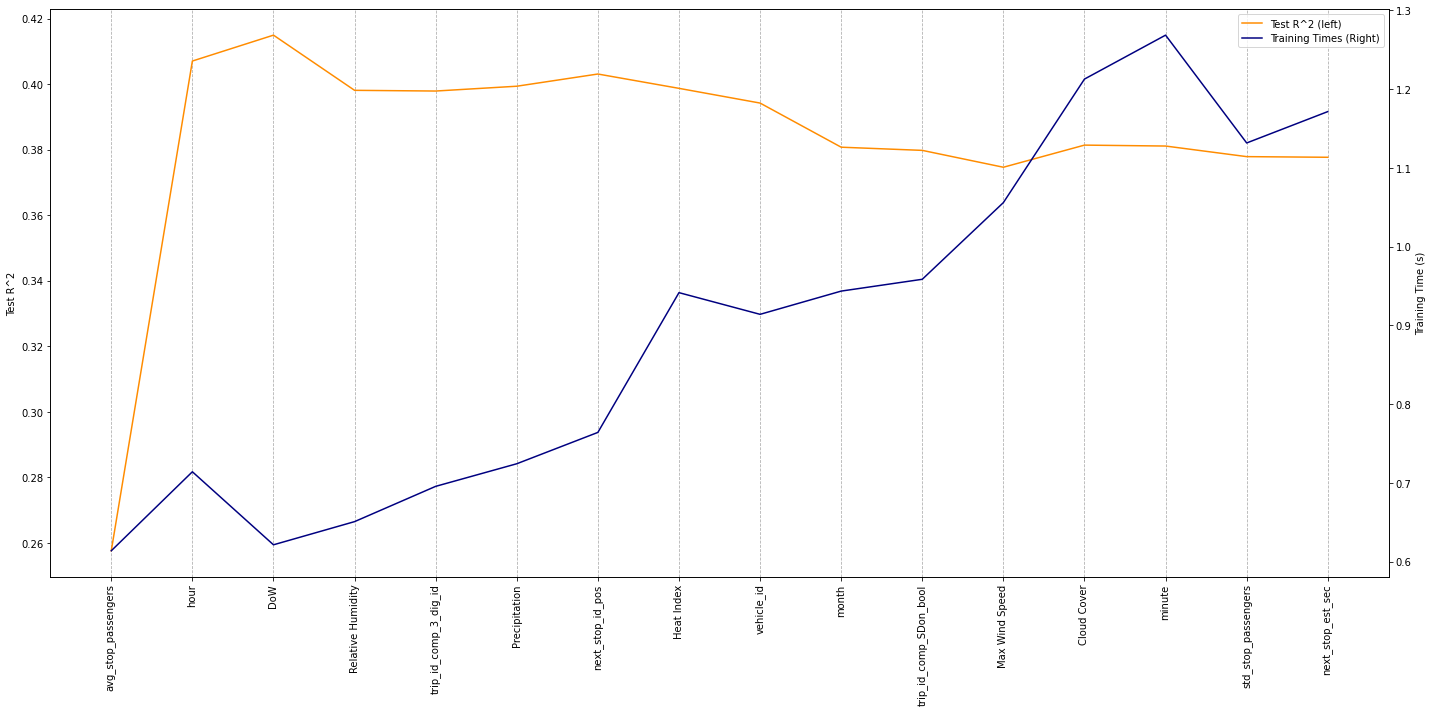

In [70]:
importance, mae, me, r2 = experiment_eval.plot_feature_importance(ablate_features=True)